# AI-Medic Assignment 4

Name: Mohammad Arabzadeh  
Email: a.mohamad7824@gmail.com

## 1. Import Libraries

In [1]:
!pip install -U -q patchify
!pip install -U -q segmentation-models # U-net model library

     |████████████████████████████████| 50 kB 5.6 MB/s 


In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

## 2. Download and Save the Dataset

First, I'll download the dataset and save the images into numpy variables. 

In [3]:
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip

--2021-09-03 06:22:16--  https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  16.0MB/s    in 12s     

2021-09-03 06:22:30 (11.7 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [4]:
!unzip -q consep.zip

In [5]:
def count_files(folder):
  """Counts the number of files in a specified folder. 
  """
  return len(next(os.walk(folder))[2])

In [6]:
def save_images(folder, file_prefix, file_format='.png'):
  """Saves image files in a specified folder. There must be only image files in
  the folder with this name format:
  "file_prefix" + "{file_number}" + "file_format", e.g.: image_1.png

  Args:
    folder (str): folder in which there are only images with the specified
                  file_format.
    file_prefix (str): prefix of the file name.
    file_format (str): format of the image file. 
  
  Returns:
    list: a list of image arrays where the first axis of the list indicates the 
          image index.
  """
  images = []
  file_count = count_files(folder)

  for idx in range(file_count):
    file = file_prefix + str(idx + 1) + file_format
    images.append(imageio.imread(os.path.join(folder, file)))

  return images

In [7]:
def save_labels(folder, file_prefix, label_name='type_map'):
  labels = []
  file_count = count_files(folder)

  for idx in range(file_count):
    file = file_prefix + str(idx + 1)
    dict_mat = loadmat(os.path.join(folder, file))
    labels.append(dict_mat['type_map'])

  return np.array(labels)

In [8]:
train_folder = './CoNSeP/Train'
test_folder = './CoNSeP/Test'

train_images = save_images(folder=os.path.join(train_folder, 'Images'), 
                           file_prefix='train_')
train_masks = save_labels(folder=os.path.join(train_folder, 'Labels'), 
                           file_prefix='train_')

test_images = save_images(folder=os.path.join(test_folder, 'Images'), 
                          file_prefix='test_')
test_masks = save_labels(folder=os.path.join(test_folder, 'Labels'),
                          file_prefix='test_')


## 3. See the Dataset Images and Masks

I've written a function to show sample images from the dataset with their corresponding masks.

In [9]:
def show_samples(images, labels, num_img=4, idx=None):
  # num_img: number of images to plot
  if idx is None:
    img_idx = np.random.choice(range(len(images)),
                               size=num_img,
                               replace=False) # index of images to plot
  else:
    img_idx = idx
    num_img = len(idx)
  
  fig, ax = plt.subplots(2, num_img)

  fig.set_figheight(2*3)
  fig.set_figwidth(num_img*3)


  for ax_idx, idx in enumerate(img_idx):
    ax[0, ax_idx].imshow(images[idx])
    ax[0, ax_idx].set_title(f"train_{idx}")
    ax[0, ax_idx].tick_params(axis='both',
                              which='both',
                              bottom=False,
                              left=False,
                              labelbottom=False,
                              labelleft=False)

  for ax_idx, idx in enumerate(img_idx):
    ax[1, ax_idx].imshow(labels[idx], cmap='hot')
    ax[1, ax_idx].tick_params(axis='both',
                              which='both',
                              bottom=False,
                              left=False,
                              labelbottom=False,
                              labelleft=False)

  fig.tight_layout(h_pad=0, w_pad=0.6)
  ax[0, 0].set_ylabel("images")
  ax[1, 0].set_ylabel("labels")

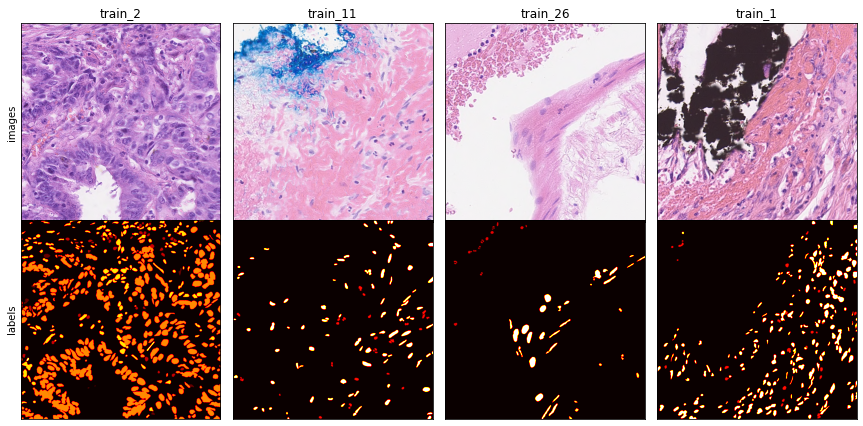

In [10]:
show_samples(train_images, train_masks)

## 4. Preprocessing

In this section I'll apply some preprocessing methods to the dataset.

In [61]:
## What are the shapes of the masks? 
print(np.array(train_masks).shape)
print(np.array(test_masks).shape)

(27, 1000, 1000)
(14, 1000, 1000)


### Removing the Forth Channel

Some of the images in the dataset have a forth channel. The forth channel is filled with all the elements set to 255. So we are safe to remove this channel for those images in order to have consistant shapes.

In [12]:
print("index" + '\t ' + "train data shape" + '\n')
for idx in range(len(train_images)):
  print(idx, '\t', train_images[idx].shape)

index	 train data shape

0 	 (1000, 1000, 3)
1 	 (1000, 1000, 3)
2 	 (1000, 1000, 3)
3 	 (1000, 1000, 3)
4 	 (1000, 1000, 3)
5 	 (1000, 1000, 3)
6 	 (1000, 1000, 3)
7 	 (1000, 1000, 3)
8 	 (1000, 1000, 3)
9 	 (1000, 1000, 3)
10 	 (1000, 1000, 3)
11 	 (1000, 1000, 3)
12 	 (1000, 1000, 3)
13 	 (1000, 1000, 3)
14 	 (1000, 1000, 3)
15 	 (1000, 1000, 3)
16 	 (1000, 1000, 3)
17 	 (1000, 1000, 3)
18 	 (1000, 1000, 3)
19 	 (1000, 1000, 3)
20 	 (1000, 1000, 4)
21 	 (1000, 1000, 4)
22 	 (1000, 1000, 4)
23 	 (1000, 1000, 4)
24 	 (1000, 1000, 4)
25 	 (1000, 1000, 4)
26 	 (1000, 1000, 4)


In [13]:
print("index" + '\t ' + "test data shape" + '\n')
for idx in range(len(test_images)):
  print(idx, '\t', test_images[idx].shape)

index	 test data shape

0 	 (1000, 1000, 3)
1 	 (1000, 1000, 3)
2 	 (1000, 1000, 3)
3 	 (1000, 1000, 3)
4 	 (1000, 1000, 3)
5 	 (1000, 1000, 3)
6 	 (1000, 1000, 3)
7 	 (1000, 1000, 3)
8 	 (1000, 1000, 3)
9 	 (1000, 1000, 3)
10 	 (1000, 1000, 3)
11 	 (1000, 1000, 4)
12 	 (1000, 1000, 4)
13 	 (1000, 1000, 3)


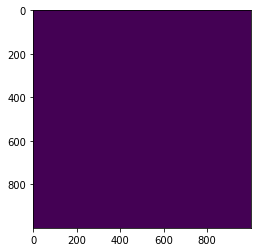

In [14]:
## what is in the forth channel?
temp = test_images[-2]
plt.imshow(temp[:, :, 3])

In [15]:
print(temp[:, :, 3], "\n")
print("minimum: ", temp[:, :, 3].min())
print("maximum: ", temp[:, :, 3].max())

del temp

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]] 

minimum:  255
maximum:  255


In [16]:
## remove the forth channel
def remove_forth_channel(images):
  for idx, image in enumerate(images):
    if image.shape[-1] == 4:
      images[idx] = np.delete(image, 3, axis=2)

In [17]:
remove_forth_channel(train_images)
remove_forth_channel(test_images)
train_images = np.array(train_images)
test_images = np.array(test_images)

The final image shapes:

In [18]:
print("index" + '\t ' + "train data shape" + '\n')
for idx in range(len(train_images)):
  print(idx, '\t', train_images[idx].shape)

index	 train data shape

0 	 (1000, 1000, 3)
1 	 (1000, 1000, 3)
2 	 (1000, 1000, 3)
3 	 (1000, 1000, 3)
4 	 (1000, 1000, 3)
5 	 (1000, 1000, 3)
6 	 (1000, 1000, 3)
7 	 (1000, 1000, 3)
8 	 (1000, 1000, 3)
9 	 (1000, 1000, 3)
10 	 (1000, 1000, 3)
11 	 (1000, 1000, 3)
12 	 (1000, 1000, 3)
13 	 (1000, 1000, 3)
14 	 (1000, 1000, 3)
15 	 (1000, 1000, 3)
16 	 (1000, 1000, 3)
17 	 (1000, 1000, 3)
18 	 (1000, 1000, 3)
19 	 (1000, 1000, 3)
20 	 (1000, 1000, 3)
21 	 (1000, 1000, 3)
22 	 (1000, 1000, 3)
23 	 (1000, 1000, 3)
24 	 (1000, 1000, 3)
25 	 (1000, 1000, 3)
26 	 (1000, 1000, 3)


In [19]:
print("index" + '\t ' + "test data shape" + '\n')
for idx in range(len(test_images)):
  print(idx, '\t', test_images[idx].shape)

index	 test data shape

0 	 (1000, 1000, 3)
1 	 (1000, 1000, 3)
2 	 (1000, 1000, 3)
3 	 (1000, 1000, 3)
4 	 (1000, 1000, 3)
5 	 (1000, 1000, 3)
6 	 (1000, 1000, 3)
7 	 (1000, 1000, 3)
8 	 (1000, 1000, 3)
9 	 (1000, 1000, 3)
10 	 (1000, 1000, 3)
11 	 (1000, 1000, 3)
12 	 (1000, 1000, 3)
13 	 (1000, 1000, 3)


### Patchify

This dataset consists of images with 1000x1000 resolutions. For the deep learning model to perform better, we should feed smaller images to it. So I'll make smaller patches of 256x256 for each image. There will be little overlaps between images which shouldn't cause any trouble. 

In [20]:
def my_patchify(images, patch_size, step):
  img_patches = []
  for image in images:
    img_patches.append(
        patchify(image, patch_size=patch_size, step=step).reshape((-1,)+
                                                                  patch_size)
        )

  return np.array(img_patches).reshape((-1,)+patch_size)

In [21]:
# step is less than patch size. this is because we don't want to lose any pixels from the original images
train_images_256 = my_patchify(train_images, patch_size=(256, 256, 3), step=256-8)
train_masks_256 = my_patchify(train_masks, patch_size=(256, 256), step=256-8)

Now let's see some of the smaller images: 

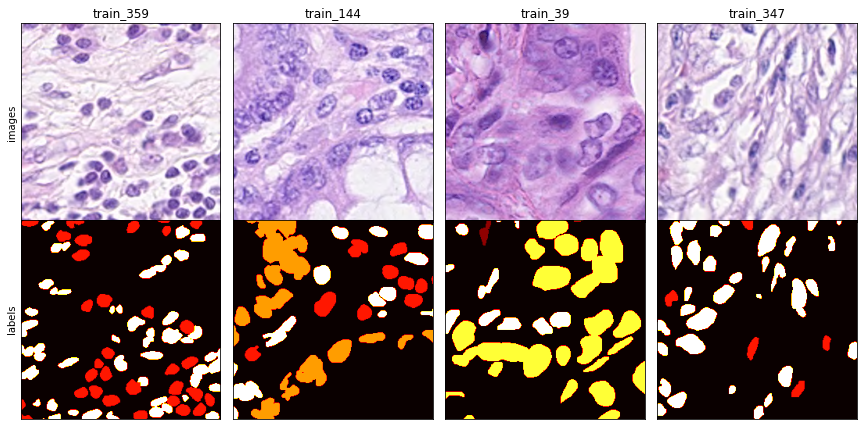

In [22]:
show_samples(train_images_256, train_masks_256)

### Resize

Before deciding to pachify images, I resized each image to 256x256. But the final results weren't satisfactory. The code below is the one that I used for resizing.

In [23]:
def resize(images, num=8, multiple_channels=True):
  """
  num: number of pixels to remove
  """
  remove = np.linspace(0, images.shape[1]-1, num=num, dtype=int)
  
  if multiple_channels:
    shape = tuple([images.shape[0],
                   images.shape[1]-num,
                   images.shape[2]-num,
                   images.shape[3]])
  else:
    shape = tuple([images.shape[0],
                   images.shape[1]-num,
                   images.shape[2]-num])

  resized = np.empty(shape, dtype=int)
  
  for idx, val in enumerate(images):
    resized[idx] = np.delete(np.delete(val, remove, axis=0), remove, axis=1)

  return resized

In [24]:
# train_images_resized = resize(train_images, num=8+23*32, multiple_channels=True)
# train_masks_resized = resize(train_masks, num=8+23*32, multiple_channels=False)

### Removing the Background Class

Based on README.txt, we have 7 classes: 

0 = background   
1 = other  
2 = inflammatory  
3 = healthy epithelial  
4 = dysplastic/malignant epithelial  
&emsp;&emsp;5 = fibroblast  
&emsp;&emsp;6 = muscle  
7 = endothelial  

The background class dominates all others, while not being usefull for the training; so I'll remove it. Therefore the new classes will be:  
0 = other  
1 = inflammatory  
2 = healthy epithelial  
3 = dysplastic/malignant epithelial  
&emsp;&emsp;4 = fibroblast  
&emsp;&emsp;5 = muscle  
6 = endothelial  

In [25]:
def no_bg_to_categorical(mask):
  return to_categorical(mask)[:, :, :, 1:]

In [26]:
cat_train_masks = no_bg_to_categorical(train_masks_256)

In [27]:
cat_train_masks.shape

(432, 256, 256, 7)

I'll also write a function to do reverse to-categorical:

In [28]:
def reverse_to_categorical(mask):
  bg = mask[:, :, :, 0]
  for idx in range(1, mask.shape[-1]):
    bg = (bg == mask[:, :, :, idx])
  bg = (~bg).astype(mask.dtype)
  return np.insert(mask, 0, bg, axis=-1).argmax(axis=-1)

### Removing the Samples with Empty Masks

Feeding training samples with little masks to the model seems to be unnecessary. So I'll remove these data samples from the dataset. 

In [29]:
empty_masks = []
for idx, val in enumerate(cat_train_masks):
  if val.sum() < 10:
    empty_masks.append(idx)

print(empty_masks)

[17, 20, 51, 52, 55, 60, 61, 64, 66, 67, 68, 75, 76, 79, 177, 230, 235, 245, 386, 388, 389, 395, 396, 398, 418, 428]


These are some of the masks with little data in them:

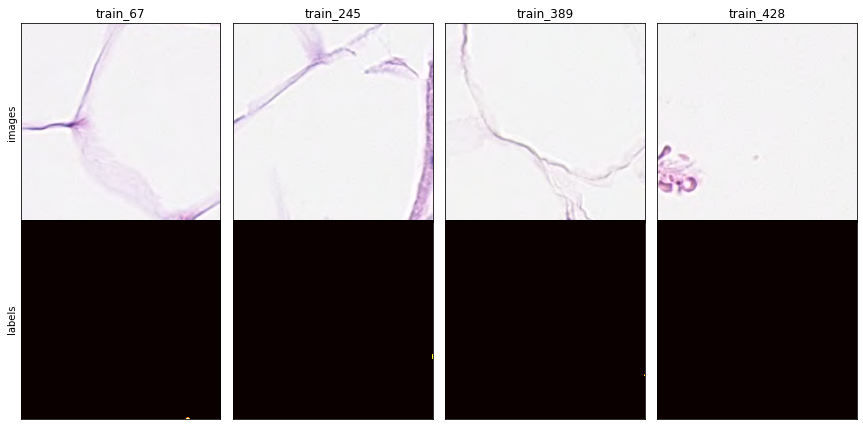

In [30]:
show_samples(train_images_256, train_masks_256, idx=[67, 245, 389, 428])

In [31]:
train_images_reduced = np.delete(train_images_256, empty_masks, axis=0)
train_masks_reduced = np.delete(train_masks_256, empty_masks, axis=0)
cat_train_masks = no_bg_to_categorical(train_masks_reduced)

In [32]:
print("Images shape:", train_images_reduced.shape)
print("Masks shape:", train_masks_reduced.shape)
print("Categorical masks shape:", cat_train_masks.shape)

Images shape: (406, 256, 256, 3)
Masks shape: (406, 256, 256)
Categorical masks shape: (406, 256, 256, 7)


### Imbalanceness

The dataset is hugely imbalanced:

In [33]:
pixel_count = []

print("class", '\t', "pixel count")
for idx in range(cat_train_masks.shape[-1]):
  pixel_count.append(np.sum(cat_train_masks[:, :, :, idx]))
  print(f"{idx}\t {pixel_count[idx]:.0f}")

pixel_count = np.array(pixel_count)

class 	 pixel count
0	 49865
1	 753502
2	 416219
3	 2028931
4	 1089014
5	 297862
6	 5956


To fix this issue I first tried to use sample_weights, with bigger weights for the smaller pixel counts. But using Jaccard loss or Dice loss without sample_weights seemed to perform better. I ended up using Jaccard loss without sample_weights. 

### Normalization

I used resnet34 as the backbone of the U-net model. As resnet34 expects the inputs to be in range [0, 255], I didn't apply any normalization to the input images. 

## 5. Augmentation

As the dataset consists of microscopic images, it is not sensative to rotations, zooming, and flipping. I've written a function bellow to make data generators for training and validation sets; But due to the long training times for the augmented dataset, and the lack of time, I decided not to use the datagenerator for the final fitting of the model. 

In [63]:
def data_generator(image, mask):
  SEED = 42 # to transform image and corresponding mask with same augmentation parameters.
  params = {
      'rotation_range': 90,
      'width_shift_range': 0.5,
      'height_shift_range': 0.5,
      'zoom_range': 0.5,
      'fill_mode': 'reflect',
      'horizontal_flip': True,
      'vertical_flip': True,
      'validation_split' : 0.2,
  }
  val_params = {
      'validation_split' : 0.2,
  }
  
  mask_preprocessing = lambda x: np.rint(x).clip(max=1.).astype(x.dtype)
                            # this will fix the interpolated values in the mask

  train_image_datagen = ImageDataGenerator(**params)
  train_mask_datagen = ImageDataGenerator(**params,
                                      preprocessing_function=mask_preprocessing)
  
  val_image_datagen = ImageDataGenerator(**val_params)
  val_mask_datagen = ImageDataGenerator(**val_params)
  
  
  train_image_generator = train_image_datagen.flow(image, seed=SEED, subset='training')
  train_mask_generator = train_mask_datagen.flow(mask, seed=SEED, subset='training')

  val_image_generator = val_image_datagen.flow(image, seed=SEED, subset='validation')
  val_mask_generator = val_mask_datagen.flow(mask, seed=SEED, subset='validation')

  # function to combine the images and masks:
  def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
      yield (img, mask)

  train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
  val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

  return (train_generator, val_generator)

In [64]:
train_generator, val_generator = data_generator(train_images_reduced, cat_train_masks)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (325, 256, 256, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (81, 256, 256, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


We can see samples of the generator outputs below:

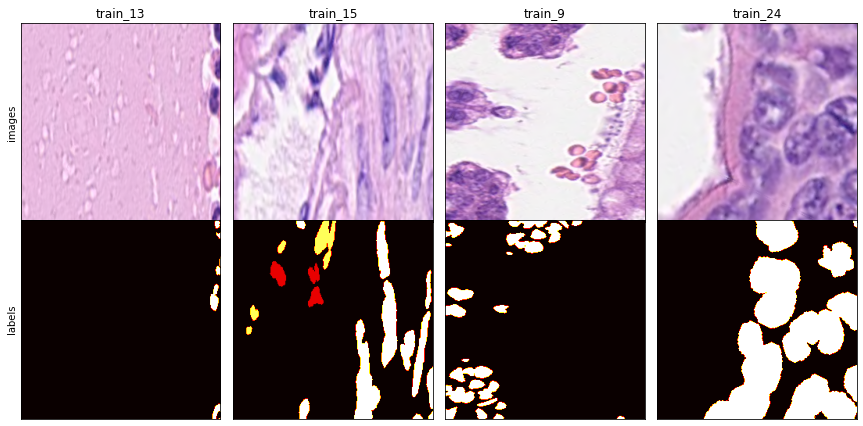

In [70]:
t = next(train_generator)
show_samples(t[0].astype(np.uint8), reverse_to_categorical(t[1]))

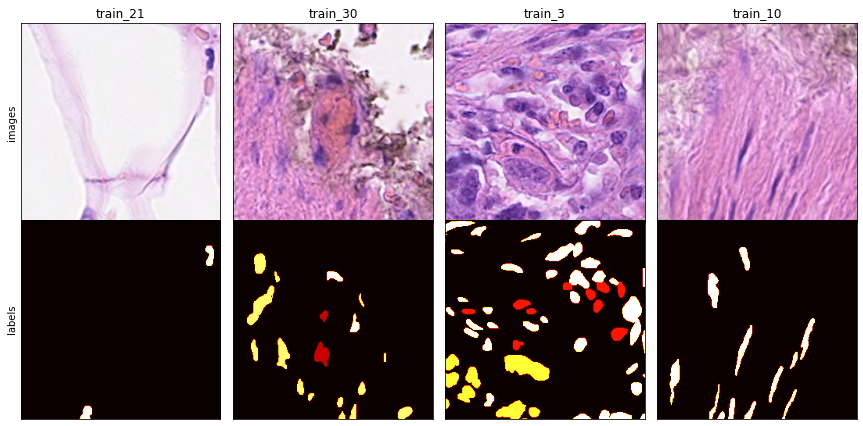

In [67]:
t = next(val_generator)
show_samples(t[0].astype(np.uint8), reverse_to_categorical(t[1]))

del t

## 6. Model

I first used 20% of the training set as cross validation and set the hyperparameters as below. Then I trained the final model using the whole training set.  
The encoder part of the U-net model is freezed and the model is fit for 40 epochs. Then I made the whole model trainable and fit the model for 12 more epochs with a smaller learning rate. 

Validation (blue) and training (red) loss curve for the first fitting:  
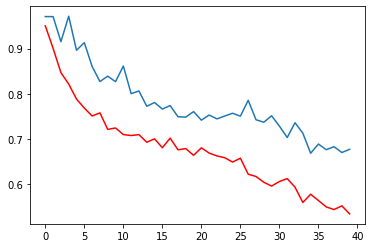

Validation (blue) and training (red) loss curve for the final fitting:  
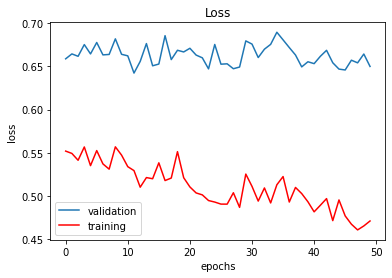

In [43]:
## Main parameters:
INPUT_SHAPE = (256, 256, 3)
CLASSES = 7
METRICS = [sm.metrics.IOUScore(name='iou'),
           sm.metrics.FScore(name='dice'),]
BACKBONE = 'resnet34'
WEIGHTS = 'imagenet'

## Hyperparameters:
LOSS = sm.losses.JaccardLoss()
OPTIMIZER = Adam
LR_1 = 0.001
EPOCHS_1 = 40
BATCH_SIZE = 16
LR_2 = 1e-5
EPOCHS_2 = 12

In [41]:
def unison_shuffle(a, b):
    inx = np.random.permutation(a.shape[0])
    return a[inx], b[inx]

In [42]:
X = train_images_reduced.copy()
Y = cat_train_masks.copy()

X, Y = unison_shuffle(X, Y)

In [44]:
## Training with freezed encoder
model = sm.Unet(BACKBONE,
                input_shape=INPUT_SHAPE,
                classes=CLASSES,
                activation='softmax',
                encoder_weights=WEIGHTS,
                encoder_freeze=True)

model.compile(
    optimizer=OPTIMIZER(LR_1),
    loss=LOSS,
    metrics=METRICS,
)

hist1 = model.fit(X, Y,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS_1,
                 )

85532672/85521592 [==============================] - 1s 0us/step
Epoch 1/40
26/26 [==============================] - 54s 600ms/step - loss: 0.9454 - iou: 0.0544 - dice: 0.0923
Epoch 2/40
26/26 [==============================] - 13s 482ms/step - loss: 0.8895 - iou: 0.1104 - dice: 0.1669
Epoch 3/40
26/26 [==============================] - 12s 481ms/step - loss: 0.8415 - iou: 0.1575 - dice: 0.2283
Epoch 4/40
26/26 [==============================] - 13s 481ms/step - loss: 0.7945 - iou: 0.2017 - dice: 0.2853
Epoch 5/40
26/26 [==============================] - 12s 480ms/step - loss: 0.7882 - iou: 0.2099 - dice: 0.2962
Epoch 6/40
26/26 [==============================] - 13s 483ms/step - loss: 0.7547 - iou: 0.2463 - dice: 0.3414
Epoch 7/40
26/26 [==============================] - 13s 482ms/step - loss: 0.7418 - iou: 0.2562 - dice: 0.3498
Epoch 8/40
26/26 [==============================] - 13s 481ms/step - loss: 0.6769 - iou: 0.3210 - dice: 0.4267
Epoch 9/40
26/26 [=============================

In [45]:
model.trainable = True
# model.summary()

In [46]:
## Fine-tuning the whole model
model.compile(
    optimizer=OPTIMIZER(LR_2),
    loss=LOSS,
    metrics=METRICS,
)
hist2 = model.fit(X, Y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS_2,
                  )

Epoch 1/12
26/26 [==============================] - 21s 561ms/step - loss: 0.5467 - iou: 0.4527 - dice: 0.5442
Epoch 2/12
26/26 [==============================] - 14s 556ms/step - loss: 0.5295 - iou: 0.4674 - dice: 0.5562
Epoch 3/12
26/26 [==============================] - 14s 556ms/step - loss: 0.5288 - iou: 0.4689 - dice: 0.5572
Epoch 4/12
26/26 [==============================] - 14s 556ms/step - loss: 0.5251 - iou: 0.4677 - dice: 0.5558
Epoch 5/12
26/26 [==============================] - 14s 555ms/step - loss: 0.5364 - iou: 0.4624 - dice: 0.5469
Epoch 6/12
26/26 [==============================] - 14s 556ms/step - loss: 0.5223 - iou: 0.4749 - dice: 0.5590
Epoch 7/12
26/26 [==============================] - 14s 554ms/step - loss: 0.5487 - iou: 0.4464 - dice: 0.5324
Epoch 8/12
26/26 [==============================] - 14s 554ms/step - loss: 0.5245 - iou: 0.4735 - dice: 0.5586
Epoch 9/12
26/26 [==============================] - 14s 556ms/step - loss: 0.5208 - iou: 0.4779 - dice: 0.5655
E

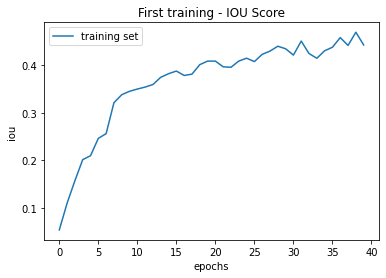

In [53]:
plt.plot(hist1.history['iou'])
plt.title("First training - IOU Score")
plt.xlabel("epochs")
plt.ylabel("iou")
plt.legend(["training set"])

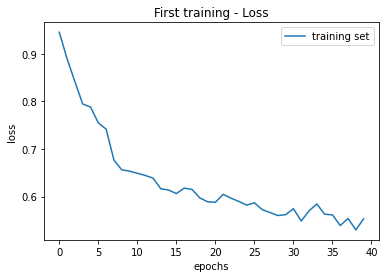

In [54]:
plt.plot(hist1.history['loss'])
plt.title("First training - Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training set"])

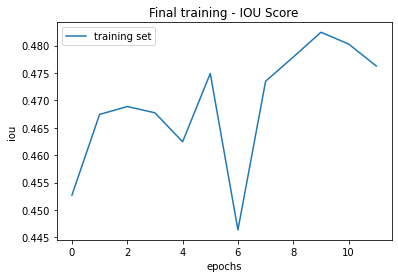

In [55]:
plt.plot(hist2.history['iou'])
plt.title("Final training - IOU Score")
plt.xlabel("epochs")
plt.ylabel("iou")
plt.legend(["training set"])

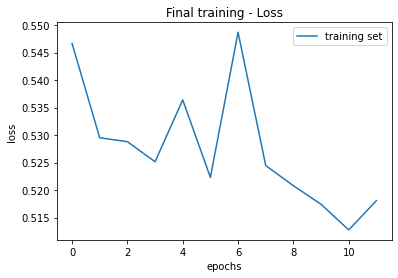

In [56]:
plt.plot(hist2.history['loss'])
plt.title("Final training - Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training set"])

In [ ]:
# hist = model.fit(train_generator,
#                  steps_per_epoch=10,
#                  epochs=10,
#                  validation_data=val_generator,
#                  validation_steps=2,
#                 #  callbacks=[checkpoint_callback],
#                  )

### Evaluating on the Test Set

In [57]:
x_test = my_patchify(test_images, patch_size=(256, 256, 3), step=256-8)

y_true = my_patchify(test_masks, patch_size=(256, 256), step=256-8)
y_pred = tf.argmax(model.predict(x_test), axis=-1).numpy()

In [58]:
print("Testing Set Evaluations:")
evaluations = model.evaluate(x_test, no_bg_to_categorical(y_true))

Testing Set Evaluations:
7/7 [==============================] - 2s 345ms/step - loss: 0.7747 - iou: 0.2253 - dice: 0.3085
